In [1]:
# Load the required packages

import pandas as pd
import numpy as np 
import re

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve

from sklearn.model_selection import GridSearchCV

# import the feature_extract file to perform feature extraction process
from feature_extract import features, prediction
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import timeit
from math import sqrt

## Phishing Dataset

In [2]:
#Load the dataset into dataframe
phishing_raw_df = pd.read_csv("Main_dataset.csv", header = 0)

In [3]:
# Dropping null values, duplicates and reset the index
phishing_raw_df = phishing_raw_df.dropna()
phishing_raw_df = phishing_raw_df.drop_duplicates()
phishing_raw_df = phishing_raw_df.reset_index(drop=True)
phishing_raw_df.shape

(72363, 12)

In [4]:
print(phishing_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72363 entries, 0 to 72362
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   domain          72363 non-null  object
 1   ranking         72363 non-null  int64 
 2   isIp            72363 non-null  int64 
 3   valid           72363 non-null  int64 
 4   activeDuration  72363 non-null  int64 
 5   urlLen          72363 non-null  int64 
 6   is@             72363 non-null  int64 
 7   isredirect      72363 non-null  int64 
 8   haveDash        72363 non-null  int64 
 9   domainLen       72363 non-null  int64 
 10  nosOfSubdomain  72363 non-null  int64 
 11  label           72363 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.6+ MB
None


Class Legitimate URL: 31025
Class Phishing URL: 41338
Proportion: 0.75 : 1


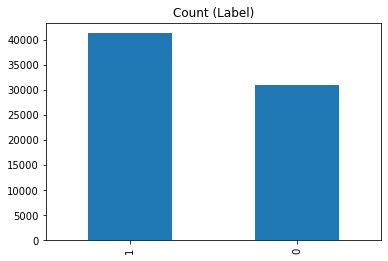

In [5]:
# Plotting a bar graph with the number of Legitimate and Phishing class urls
target_count = phishing_raw_df.label.value_counts()
print('Class Legitimate URL:', target_count[0])
print('Class Phishing URL:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (Label)');

Random under-sampling:
0    31025
1    31025
Name: label, dtype: int64


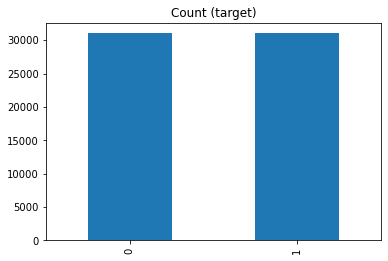

In [6]:
# Each Class count
count_class_1, count_class_0 = phishing_raw_df.label.value_counts()

# Divide by each class
df_class_0 = phishing_raw_df[phishing_raw_df['label'] == 0]
df_class_1 = phishing_raw_df[phishing_raw_df['label'] == 1]

# As the class 1 values are more than to class 0,
# Undersampling is performed to avoid bias and have same number of urls in both classes
df_class_1_under = df_class_1.sample(count_class_0)
phishing_raw_df = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(phishing_raw_df.label.value_counts())

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (target)');

In [7]:
# Viewing sample data from dataframe
phishing_raw_df.head()

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
12594,app.qmailer.co.uk/link/8556/3622822/179552,836190,0,0,0,42,0,0,0,17,3,1
34846,adisurya.com/belajar-excel/login.htm,10000000,0,1,4383,36,0,0,0,12,1,1
53449,www490.paypal.ca.92615.securessl-100.mx/js/web...,10000000,0,0,0,97,0,0,1,39,5,1
45085,www.peedomain.info/~everythi/klm/9c9dc232c1d68...,10000000,0,0,0,66,0,0,0,18,2,1
40960,umefnbkes.net63.net/spt/verify.htm,10000000,0,1,4383,34,0,0,0,19,2,1


## Data Pre-processing

In [8]:
# object created for the features class imported from feature_extract file
feature = features()

In [9]:
# Feature engineering
#call_type = 'model'
# Insert a new column to the dataframe which shows if 'http' is found in the domain part of the URL.
phishing_raw_df["Domain_http"] = phishing_raw_df["domain"].apply( lambda x: feature.httpDomain(x))

# Insert a new column to the dataframe indicating the length of the URL.
phishing_raw_df["LongURL"] = phishing_raw_df["domain"].apply( lambda x: feature.LongURL(x))

# Insert a new column to the dataframe indicating if the URL belongs to any of the shortening services.
phishing_raw_df["TinyURL"] = phishing_raw_df["domain"].apply( lambda x: feature.tinyURL(x))

# Alter the values in 'nosOfSubdomain' column of the dataframe.
# If the number of sub domains is more than 1, then it is a phishing site.
phishing_raw_df["nosOfSubdomain"] = phishing_raw_df["domain"].apply( lambda x: feature.no_sub_domain(x))

# Alter the values in 'activeDuration' column of the dataframe.
# If the value is greater than 365 (1 year), then it is a legitimate site.
phishing_raw_df["activeDuration"] = phishing_raw_df["activeDuration"].apply( lambda x: 1 if x <= 365 else 0)

# Alter the values in the dataframe column 'ranking'
# If the value is greater than 100000, then it is a phishing site
phishing_raw_df["ranking"] = phishing_raw_df["ranking"].apply( lambda x: 0 if x < 100000 else 1)

# Remove the unwanted columns from the dataframe
phishing_raw_df.drop(['urlLen','domainLen','domain'], inplace=True,axis=1)

# Reorder and rename the columns in the dataframe
Columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Label','Domain_http','LongURL','TinyURL']
new_columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Domain_http','LongURL','TinyURL','Label']
phishing_raw_df.columns = Columns
phishing_raw_df = phishing_raw_df.reindex(columns=new_columns)

# Shuffle the rows in the dataset so that when splitting the train and test set are equally distributed

phishing_raw_df = phishing_raw_df.sample(frac=1).reset_index(drop=True)

# Save the dataframe to a csv file
phishing_raw_df.to_csv('phishing_feature_engg.csv', encoding='utf-8')

#Display the dataset after feature engineering

phishing_raw_df.head()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
0,1,0,0,1,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,1,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,0,0


In [10]:
phishing_raw_df.isnull().sum()

Rank              0
isIP              0
isValid           0
Domain_reg_len    0
is@               0
isRedirect        0
haveDash          0
SubDomain         0
Domain_http       0
LongURL           0
TinyURL           0
Label             0
dtype: int64

In [11]:
phishing_raw_df.describe()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
count,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.0,62050.000000,62050.000000,62050.000000
mean,0.662853,0.000177,0.592828,0.412377,0.002498,0.006446,0.143384,0.549686,0.0,0.353086,0.069847,0.500000
std,0.472740,0.013313,0.491311,0.492266,0.049918,0.080031,0.350467,0.497529,0.0,0.477933,0.254891,0.500004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.500000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


<AxesSubplot:>

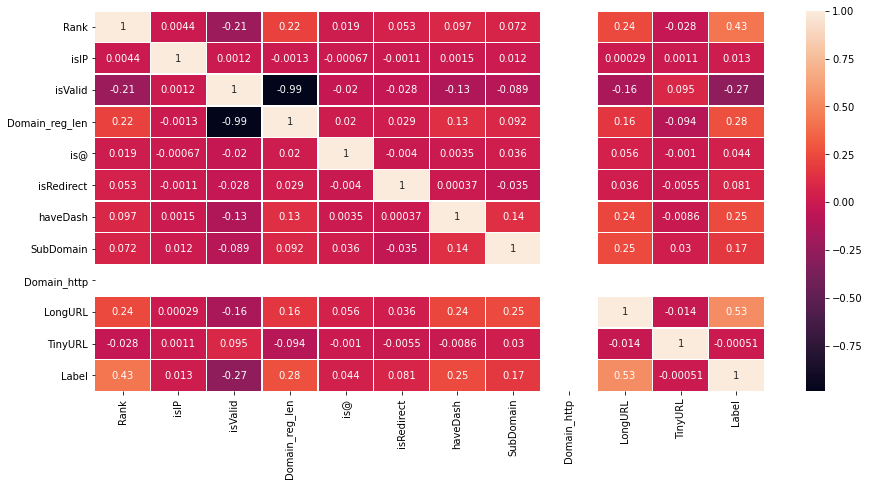

In [12]:
plt.figure(figsize=(15,7))
sns.heatmap(phishing_raw_df.corr(),annot=True, linewidth=0.5)

In [1]:
# Label column was dropped and stored the feature data in X
X=phishing_raw_df.drop(["Label"],axis=1)

# store the labels in y
Y=phishing_raw_df["Label"]

#split the data
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=101)
data_classes = ['0','1']

NameError: name 'phishing_raw_df' is not defined

In [14]:
# fit the data with decision tree classifier
dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5)
dtc = dtc.fit(X_train,y_train)

In [15]:
#predict the test and train data
y_pred_test = dtc.predict(X_test)
y_pred_train = dtc.predict(X_train)

In [16]:
acc_train_dtc = accuracy_score(y_train,y_pred_train)
acc_test_dtc = accuracy_score(y_test,y_pred_test)

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_dtc))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_dtc))

Decision Tree: Accuracy on training Data: 0.822
Decision Tree: Accuracy on test Data: 0.820


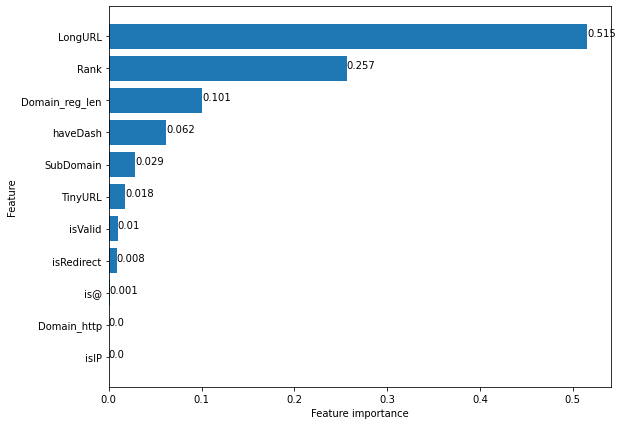

In [17]:
# Get the feature importance for all the features, from the decision tree classifier
importances = dtc.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), importances[indices], align='center')
plt.yticks(np.arange(n_features), X_train.columns[indices])
for index, value in enumerate(importances[indices]):
    plt.text(value, index, str(round(value,3)))
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()


In [18]:
# Drop the features with least importance
phishing_raw_df.drop(["isIP","Domain_http","is@"],inplace=True,axis=1)
X = phishing_raw_df.iloc[:, :8]
Y = phishing_raw_df["Label"]

In [19]:
# split the train and test data, after dropping least important features
X_train, X_test, y_train, y_test = train_test_split(X.values,Y.values, test_size=0.3, random_state=101)

### XGBoost

In [20]:
def XG_Boost_classifier():
    
    global XGB_model
    #calculating start time
    starttime = timeit.default_timer()
    XGB_model = XGBClassifier(random_state=100)
    XGB_model.fit(X_train, y_train)

    pred_XGB_test=XGB_model.predict(X_test)
    pred_XGB_train=XGB_model.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- XGBoost ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_XGB_test, target_names=['0','1']))
    kappa_XGB = cohen_kappa_score(y_test, pred_XGB_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_XGB_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())

    plot_precision_recall_curve(XGB_model, X_test, y_test, name = 'XGBoost')
    return (('XGBoost',accuracy_score(y_train,pred_XGB_train),accuracy_score(y_test,pred_XGB_test),kappa_XGB, time))


## Decision Tree

In [21]:
def Decision_Tree_classifier():
    
    global DTC_model
    #calculating start time
    starttime = timeit.default_timer()
    DTC_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5)
    DTC_model.fit(X_train,y_train)

    pred_dtc_test = DTC_model.predict(X_test)
    pred_dtc_train = DTC_model.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Decision Tree ----------\n')
    print('Classification Report :\n', classification_report(y_test, pred_dtc_test, target_names=['0','1']))
    kappa_dtc = cohen_kappa_score(y_test, pred_dtc_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_dtc_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())

    plot_precision_recall_curve(DTC_model, X_test, y_test, name = 'Decision Tree')
    return (('Decision Tree',accuracy_score(y_train,pred_dtc_train),accuracy_score(y_test,pred_dtc_test), kappa_dtc, time))

## Neural Network

In [22]:
def Neural_Network_classifier():
    
    global MLP_model
#training the neural network with 3 layers 
#features_train, features_test, target_train, target_test = train_test_split(X,Y, test_size=0.3, random_state=17)
    #calculating start time
    starttime = timeit.default_timer()
    MLP_model = MLPClassifier(hidden_layer_sizes=(12,12,12), activation='relu', solver='adam', max_iter=500)
    MLP_model.fit(X_train,y_train)
    
    pred_NN_test = MLP_model.predict(X_test)
    pred_NN_train = MLP_model.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Neural Network ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_NN_test, target_names=['0','1']))
    kappa_NN = cohen_kappa_score(y_test, pred_NN_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_NN_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    plot_precision_recall_curve(MLP_model, X_test, y_test, name = 'Neural Network')
    return (('Neural Network',accuracy_score(y_train,pred_NN_train),accuracy_score(y_test,pred_NN_test), kappa_NN, time))

# SVM

In [23]:
def Svm_classifier():
    
    global SVM_model
    #calculating start time
    starttime = timeit.default_timer()
    SVM_model = SVC(kernel='linear', C=1.0, random_state=100)
    SVM_model.fit(X_train, y_train)
    
    pred_svm_test = SVM_model.predict(X_test)
    pred_svm_train = SVM_model.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- SVM ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_svm_test, target_names=['0','1']))
    kappa_svm = cohen_kappa_score(y_test, pred_svm_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_svm_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    plot_precision_recall_curve(SVM_model, X_test, y_test, name = 'SVM')
    return (('SVM',accuracy_score(y_train,pred_svm_train),accuracy_score(y_test,pred_svm_test), kappa_svm, time))

# Naive Bayes

In [24]:
def Naive_Bayes_classifier():
    
    global NBC_model

    #calculating start time
    starttime = timeit.default_timer()
    NBC_model = BernoulliNB()
    NBC_model.fit(X_train,y_train)
    
    pred_nb_test = NBC_model.predict(X_test)
    pred_nb_train = NBC_model.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Naive Bayes ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_nb_test, target_names=['0','1']))
    kappa_nb = cohen_kappa_score(y_test, pred_nb_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_nb_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    plot_precision_recall_curve(NBC_model, X_test, y_test, name = 'Naive Bayes')
    return (('Naive Bayes',accuracy_score(y_train,pred_nb_train),accuracy_score(y_test,pred_nb_test),kappa_nb, time))

# Logistic Regression

In [25]:
def Logistic_Regression_classifier():
    
    global LOG_model

    #calculating start time
    starttime = timeit.default_timer()
    LOG_model = LogisticRegression(random_state=100)
    LOG_model.fit(X_train,y_train)
    
    pred_logreg_test = LOG_model.predict(X_test)
    pred_logreg_train = LOG_model.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Logistic Regression ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_logreg_test, target_names=['0','1']))
    kappa_lg =  cohen_kappa_score(y_test, pred_logreg_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_logreg_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    plot_precision_recall_curve(LOG_model, X_test, y_test, name = 'Logistic Regression')
    return (('Logistic Regression',accuracy_score(y_train,pred_logreg_train),accuracy_score(y_test,pred_logreg_test),kappa_lg, time))

# RandomForest

In [26]:
def Random_Forest_classifier():
    
    global RFC_model
    #calculating start time
    starttime = timeit.default_timer()
    RFC_model = RandomForestClassifier(criterion='entropy',random_state=100)
    RFC_model.fit(X_train, y_train)
    
    pred_RF_test = RFC_model.predict(X_test)
    pred_RF_train = RFC_model.predict(X_train)
    # calculating over all time taken
    time = timeit.default_timer() - starttime
    print('\n---------- Random Forest ----------\n')
    print('Classification Report:\n', classification_report(y_test, pred_RF_test, target_names=['0','1']))
    kappa_rf = cohen_kappa_score(y_test, pred_RF_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_RF_test),display_labels=['0','1'])
    print('\nconfusion matrix:\n',disp.plot())
    plot_precision_recall_curve(RFC_model, X_test, y_test, name = 'Random Forest')
    return (('Random Forest',accuracy_score(y_train,pred_RF_train),accuracy_score(y_test,pred_RF_test),kappa_rf, time))

# ROC

In [27]:
def Roc_curves():
    plt.figure()
# Add the models to the list that you want to view on the ROC plot
    models = [
    {
        'label': 'Logistic Regression',
        'model': LogisticRegression(random_state=100),
    },
    {
        'label': 'SVM',
        'model': SVC(kernel='linear', C=1.0, random_state=100,probability=True),
    },
    {
        'label': 'NaiveBayes',
        'model': BernoulliNB(),
    },
    {
        'label': 'Decision Tree',
        'model': DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 5),
    },
    {
        'label': 'RandomForest',
        'model': RandomForestClassifier(criterion='entropy',random_state=100)
    },
    {
        'label': 'XGBoost',
        'model': XGBClassifier(random_state=100),
    },
    {
        'label': 'Neural Network',
        'model': MLPClassifier(hidden_layer_sizes=(12,12,12), activation='relu', solver='adam', max_iter=500)
    }
    ]

    # Below for loop iterates through your models list
    for m in models:
        model = m['model'] # select the model
        model.fit(X_train, y_train) # train the model
        y_pred=model.predict(X_test) # predict the test data
    # Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display


---------- Logistic Regression ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      9332
           1       0.80      0.81      0.80      9283

    accuracy                           0.80     18615
   macro avg       0.80      0.80      0.80     18615
weighted avg       0.80      0.80      0.80     18615


confusion matrix:

---------- Naive Bayes ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      9332
           1       0.80      0.80      0.80      9283

    accuracy                           0.80     18615
   macro avg       0.80      0.80      0.80     18615
weighted avg       0.80      0.80      0.80     18615


confusion matrix:

---------- SVM ----------

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.91      0.81      9332
           1       

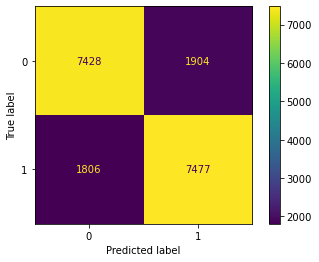

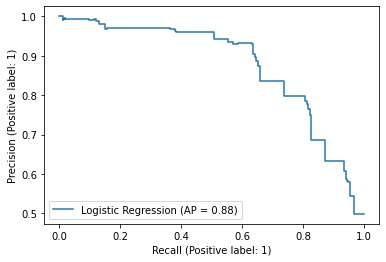

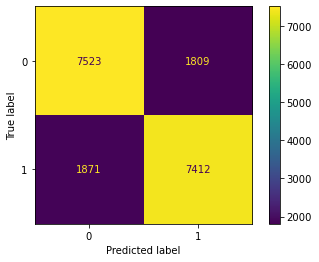

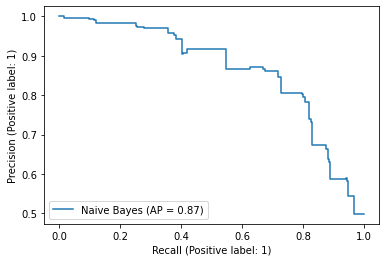

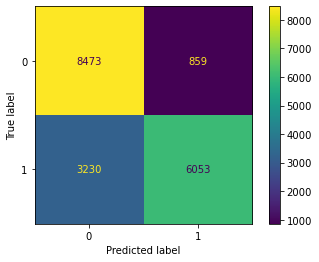

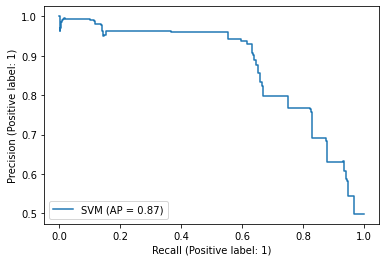

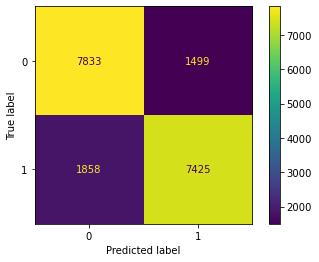

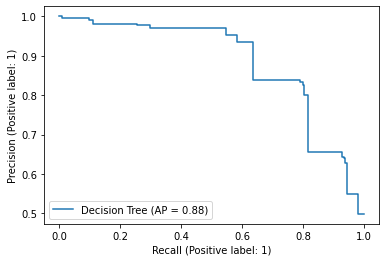

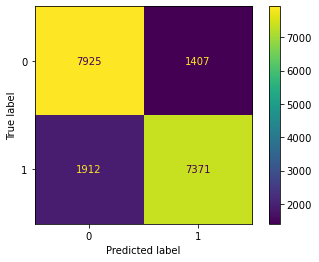

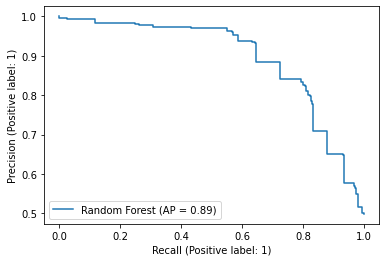

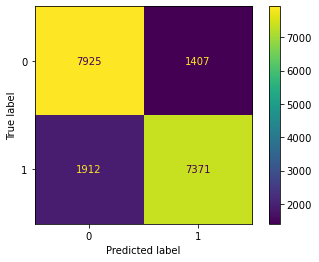

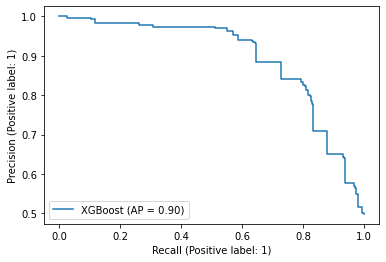

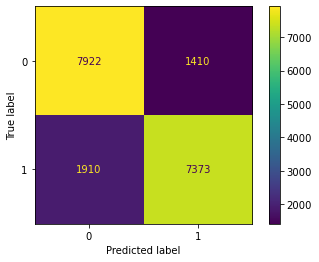

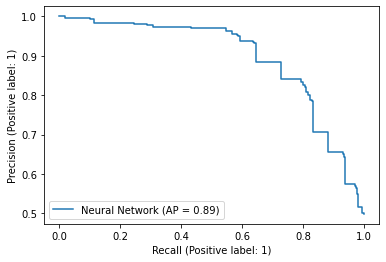

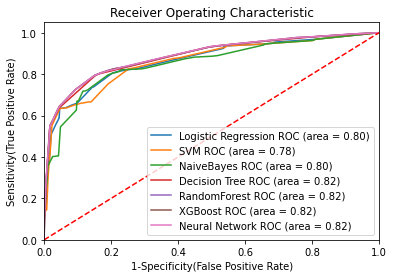

,ML Model,Train Accuracy,Test Accuracy,Kappa Score,time
0,Logistic Regression,0.798550,0.800698,0.601405,0.142025
1,Naive Bayes,0.802210,0.802310,0.604610,0.013414
2,SVM,0.778451,0.780338,0.560379,70.024718
3,Decision Tree,0.821872,0.819662,0.639284,0.012324
4,Random Forest,0.822770,0.821703,0.643352,1.020982
5,XGBoost,0.822770,0.821703,0.643352,1.002106
6,Neural Network,0.822747,0.821649,0.643245,4.207255


In [28]:
# calling all the ML models to get performace of each model
def call_ml_models():
    kappa_list = []
    ML_Model = []
    acc_train = []
    acc_test = []
    time_list = []
    model_list = [Logistic_Regression_classifier,Naive_Bayes_classifier,Svm_classifier,Decision_Tree_classifier,Random_Forest_classifier,XG_Boost_classifier,Neural_Network_classifier]
    for model in model_list: 
        res = model()
        ML_Model.append(res[0])
        acc_train.append(res[1])
        acc_test.append(res[2])
        kappa_list.append(res[3]) 
        time_list.append(res[4])
    Roc_curves()
        
    return ML_Model,acc_train,acc_test,kappa_list,time_list  

ML_Model,acc_train,acc_test,kappa_list,time_list = call_ml_models()
results = pd.DataFrame({ 'ML Model': ML_Model, 
    'Train Accuracy': acc_train,
    'Test Accuracy': acc_test, 'Kappa Score': kappa_list, 'time': time_list})
results

In [29]:
# Pickling the final model
def save_model(model):
    with open('phishing_classifier.pkl', 'wb') as f:
        pickle.dump(model, f, -1)
        f.close()

In [30]:
param_grid = { 'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
                'criterion' :['gini', 'entropy']
}

In [31]:
# Using Grid search to find the hyper parameters and finetune
RFC_grid = GridSearchCV(estimator=RFC_model, param_grid=param_grid, cv= 5)
RFC_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=100),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [32]:
RFC_model_best = RFC_grid.best_estimator_

In [33]:
RFC_model_best.fit(X_train, y_train)
pred_RF_test = RFC_model_best.predict(X_test)
pred_RF_train = RFC_model_best.predict(X_train)

kappa_rf = cohen_kappa_score(y_test, pred_RF_test)
train_acc = accuracy_score(y_train,pred_RF_train)
test_acc = accuracy_score(y_test,pred_RF_test)

print('Kappa: ',kappa_rf)
print('Train accuracy: ',train_acc)
print('Test accuracy: ',test_acc)

Kappa:  0.6432454958515739
Train accuracy:  0.8227466328997353
Test accuracy:  0.8216492076282568


In [34]:
save_model(RFC_model_best)

In [35]:
classification = prediction()

In [39]:
%%time
#classification.predict('https://www.sjsu.okta.com')
classification.predict('sjsu.com')

CPU times: user 47.9 ms, sys: 4.55 ms, total: 52.4 ms
Wall time: 246 ms


'Given website is a phishing site'

In [ ]:
#%run feature_extract.py